Sources: 
* https://www.andrew.cmu.edu/course/18-661/lectures/pytorch.pdf
* https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
* https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
* https://coderzcolumn.com/tutorials/artificial-intelligence/how-to-use-glove-embeddings-with-pytorch#3
* https://huggingface.co/course/chapter1/4?fw=pt

# Prepare Environment

In [1]:
!nvidia-smi

Thu Mar 30 20:10:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade pip
!pip uninstall -y fastai
!pip install torch==2.0.0 transformers[torch]==4.27.3 datasets==2.10.1 torchtext livelossplot tqdm

In [3]:
import torch
torch.__version__

'2.0.0+cu117'

# Torch 101

### Tensors
Tensors are very similar to numpy.ndarrays, with the extra support of performing operations on those on GPUs

Thus we have to tell PyTorch where we want to place these tensors and be careful when performing operations

Let’s have a look at Tensors in action!

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
t1 = torch.rand((100, 30), dtype=torch.float32)
t2 = torch.rand((100, 30), dtype=torch.float32)
print(t1.shape, t2.shape)
print((t1.mT @ t2).device)

torch.Size([100, 30]) torch.Size([100, 30])
cpu


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

t1 = t1.to(device)
t2 = t2.to(device)

print(t1.device, t2.device)
print((t1.mT @ t2).device)

cuda:0 cuda:0
cuda:0


### Autograd
It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

torch.Tensor is the central class of the package. If you set its
attribute `.requires_grad = True`, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with `torch.no_grad():`

---

**Pipeline**

* Initialize parameters
* Repeat until convergence:
  * Compute Loss
  * Compute gradients of the Loss function w.r.t parameter (The autograd package provides automatic differentiation for all operations on Tensors.)
  * Update parameters

In [ ]:
t1 = torch.rand((100, 30), dtype=torch.float32, requires_grad=True)
t2 = torch.rand((100, 30), dtype=torch.float32, requires_grad=True)

loss = torch.sum((t1 - t2)**2)
print(loss)
loss.backward()

t1 = t1 - 0.1 * t1.grad

loss = torch.sum((t1 - t2)**2)
print(loss)

tensor(500.9398, grad_fn=<SumBackward0>)
tensor(320.6015, grad_fn=<SumBackward0>)


### torch.nn

`torch.nn` provides a very easy way to implement Neural Networks by stacking different basic layers!

It relies on `torch.autograd` to calculate the gradients for each of the model parameters, and thus we don’t need to worry about implementing the backpropogation

Example: Y = 2*x

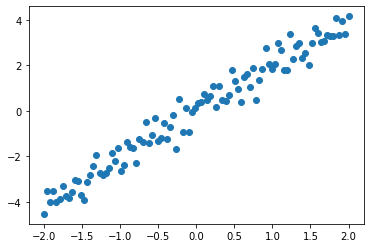

In [ ]:
X = np.linspace(-2, 2, 100)

noise = np.random.normal(0,0.5,100)
Y = 2 * X + noise

plt.scatter(X, Y)

In [ ]:
module = torch.nn.Linear( # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    in_features=1,
    out_features=1,
    bias=False,
)

print('state_dict: ', module.state_dict())

tensor_X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
tensor_Y = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)

state_dict:  OrderedDict([('weight', tensor([[-0.9400]]))])


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(module.parameters(), lr=0.01)

for step in range(210):
  optimizer.zero_grad()
  outputs = module(tensor_X)
  loss = criterion(outputs, tensor_Y)
  loss.backward()
  optimizer.step()
  
  if step % 20 == 0:
    print(f"Step={step:3d}; loss={loss.cpu().detach().item():3.3f}")

Step=  0; loss=12.131
Step= 20; loss=4.167
Step= 40; loss=1.524
Step= 60; loss=0.647
Step= 80; loss=0.356
Step=100; loss=0.260
Step=120; loss=0.228
Step=140; loss=0.217
Step=160; loss=0.214
Step=180; loss=0.212
Step=200; loss=0.212


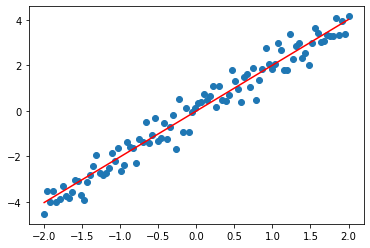

In [ ]:
k = module.state_dict()['weight'].cpu().detach().item()

plt.scatter(X, Y)
plt.plot(X, k*X, color='red')

In [ ]:
# All modules in pyTorch inherited from torch.nn.Module
assert isinstance(module, torch.nn.Module) is True

# You can write your own Module as a wrapper for other modules:
class MyAwesomeModule(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(1, 1, bias=True)

  def forward(self, input_tensor):
    return self.linear(input_tensor)

**TODO** Write your own module for same problem and test it! Instead of torch.nn.Linear using just tensor. Hint, use torch.nn.Parameter

In [ ]:
class MyAwesomeModuleLinear(torch.nn.Module):
  def __init__(self,):
    super().__init__()
    self.w = torch.nn.Parameter(torch.tensor([[-0.9400]], dtype=torch.float32))
  
  def forward(self, x):
    return x @ self.w.T

In [ ]:
module.w

Parameter containing:
tensor(1., requires_grad=True)

In [ ]:
module = MyAwesomeModuleLinear(1, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(module.parameters(), lr=0.01)

for step in range(210):
  optimizer.zero_grad()
  outputs = module(tensor_X)
  loss = criterion(outputs, tensor_Y)
  loss.backward()
  optimizer.step()
  
  if step % 20 == 0:
    print(f"Step={step:3d}; loss={loss.cpu().detach().item():3.3f}")

Step=  0; loss=12.131
Step= 20; loss=4.166
Step= 40; loss=1.524
Step= 60; loss=0.647
Step= 80; loss=0.356
Step=100; loss=0.260
Step=120; loss=0.228
Step=140; loss=0.217
Step=160; loss=0.214
Step=180; loss=0.212
Step=200; loss=0.212


# NLP

## TF-IDF & LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import datasets

In [ ]:
ds = datasets.load_dataset('imdb')
ds

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We starting from preparing text data to some vector view for fitting neural network. One of most simplest and popular method - [Term Frequency-Inverse Document Frequency (TF-IDF)](https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183). 

In [ ]:
VOCAB_SIZE = 16384

tfidf_vectorizer = TfidfVectorizer(max_features=VOCAB_SIZE, stop_words="english")
tfidf_vectorizer.fit(ds['train']['text'])

train_X_tensor = torch.tensor(tfidf_vectorizer.transform(ds['train']['text']).todense(), dtype=torch.float32)
train_Y_tensor = torch.tensor(ds['train']['label'], dtype=torch.float32).reshape(-1, 1)

# Shuffle train data
shuffle_train_index = np.random.shuffle(np.arange(train_X_tensor.shape[0]))
train_X_tensor = train_X_tensor[shuffle_train_index]
train_Y_tensor = train_Y_tensor[shuffle_train_index]

print("train_Y_tensor: ", train_Y_tensor[:10])

test_X_tensor = torch.tensor(tfidf_vectorizer.transform(ds['test']['text']).todense(), dtype=torch.float32)
test_Y_tensor = torch.tensor(ds['test']['label'], dtype=torch.float32).reshape(-1, 1)

print(train_X_tensor.shape, train_Y_tensor.shape, test_X_tensor.shape, test_Y_tensor.shape)

train_Y_tensor:  tensor([[[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]]])
torch.Size([1, 25000, 16384]) torch.Size([1, 25000, 1]) torch.Size([25000, 16384]) torch.Size([25000, 1])


In [ ]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, vocab_size):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(vocab_size, 1)

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from tqdm.auto import tqdm

model = LogisticRegression(VOCAB_SIZE)
print(f"Model size: {count_parameters(model)} parameters")
model = torch.compile(model)

# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for step in tqdm(range(1100)):
  model.train()

  # TODO: Make gradient step for updating weights
  optimizer.zero_grad()
  outputs = model(train_X_tensor)
  loss = criterion(outputs, train_Y_tensor)
  loss.backward()
  optimizer.step()
  
  if step % 100 == 0:
    with torch.no_grad():
      model.eval()
      test_outputs = model(test_X_tensor)
      test_loss = criterion(test_outputs, test_Y_tensor)
    
    print(f"step={step:4d}; train_loss={loss.cpu().detach().item():3.6f}; test_loss={test_loss.cpu().detach().item():3.6f}")

Model size: 16385 parameters


  0%|          | 0/1100 [00:00<?, ?it/s]

step=   0; train_loss=0.693127; test_loss=0.693075
step= 100; train_loss=0.690009; test_loss=0.693075
step= 200; train_loss=0.686946; test_loss=0.693075
step= 300; train_loss=0.683932; test_loss=0.693075
step= 400; train_loss=0.680968; test_loss=0.693075
step= 500; train_loss=0.678050; test_loss=0.693075
step= 600; train_loss=0.675179; test_loss=0.693075
step= 700; train_loss=0.672353; test_loss=0.693075
step= 800; train_loss=0.669571; test_loss=0.693075
step= 900; train_loss=0.666832; test_loss=0.693075
step=1000; train_loss=0.664135; test_loss=0.693075


Lets revrite our code to really using mini-batch SGD! by [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

`DataLoader` can work with [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) objects. All you need for Dataset object is implement methods `__len__` and `__getitem__` for taking data example. But we can push Huggingface dataset to DataLoader directly and it will work, but right now, let's implement our own Dataset with TFIDF

In [ ]:
class IMDBTfidfDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, tfidf_vectorizer):
    super().__init__()
    self.dataset = dataset
    self.tfidf_vectorizer = tfidf_vectorizer
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    text = self.dataset[idx]['text']
    if not isinstance(text, list):
      text = [text]

    x = self.tfidf_vectorizer.transform(text).todense()
    
    y = self.dataset[idx]['label']
    if not isinstance(y, list):
      y = [y]

    return {
        'text': torch.tensor(x, dtype=torch.float32),
        'label': torch.tensor(y, dtype=torch.float32)
    }

In [ ]:
train_dataset = IMDBTfidfDataset(
    ds['train'].train_test_split(test_size=0.1)['test'],
    tfidf_vectorizer,
  )
test_dataset = IMDBTfidfDataset(
    ds['test'].train_test_split(test_size=0.1)['test'],
    tfidf_vectorizer,
)

for batch in torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True):
  print(batch['text'].shape, batch['label'].shape)
  break

torch.Size([32, 1, 16384]) torch.Size([32, 1])


## Go Deeper

In [ ]:
# TODO: Implement Deep Feed Forward NN of at least 2 layers

class DFFNN(torch.nn.Module):
  def __init__(self, ):
    super().__init__()
    self.linear = torch.nn.Linear(VOCAB_SIZE, 100)
    self.relu = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(100, 1)
  
  def forward(self, x):
    # Don't forget about applying new layers here
    _x = self.linear(torch.squeeze(x, 1))
    _x = self.linear2(self.relu(_x))
    return torch.sigmoid(_x)


def fit_model_epoch(model, dataloader, optimizer, criterion) -> float:
  mean_loss = 0
  for batch in tqdm(dataloader):
    optimizer.zero_grad()
    outputs = model(batch['text'].to(device))
    loss = criterion(outputs, batch['label'].to(device))
    loss.backward()
    optimizer.step()

    mean_loss += loss.cpu().detach().item()
  return mean_loss / len(dataloader)


# TODO: Implement Evaluationg for dataloader
def evaluate_model(model, dataloader, criterion) -> float:
  mean_loss = 0
  with torch.no_grad():
    for batch in dataloader:
      outputs = model(batch['text'].to(device))
      loss = criterion(outputs, batch['label'].to(device))
      mean_loss += loss.cpu().detach().item()
  return mean_loss / len(dataloader)



model = DFFNN().to(device)
print(f"Model size: {count_parameters(model)} parameters")
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

NUMBER_OF_EPOCHES = 2
for epoch in range(NUMBER_OF_EPOCHES):
  train_loss = fit_model_epoch(model, train_loader, optimizer, criterion)
  test_loss = evaluate_model(model, test_loader, criterion)

  print(epoch, train_loss, test_loss)

Model size: 1638601 parameters


  0%|          | 0/79 [00:00<?, ?it/s]

0 0.6931784220888645 0.6932959073706518


  0%|          | 0/79 [00:00<?, ?it/s]

1 0.6928443870966947 0.6925686326207994


## Dropout

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout

class DFFNNWithDropout(torch.nn.Module):
  def __init__(self, ):
    super().__init__()
    self.linear = torch.nn.Linear(VOCAB_SIZE, 100)
    self.relu = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(100, 1)
    self.dropout = torch.nn.Dropout(0.5)
  
  def forward(self, x):
    # Don't forget about applying new layers here
    _x = self.dropout(self.linear(torch.squeeze(x, 1)))
    _x = self.linear2(self.relu(_x))
    return torch.sigmoid(_x)


model = DFFNNWithDropout().to(device)
print(f"Model size: {count_parameters(model)} parameters")


criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NUMBER_OF_EPOCHES = 2
for epoch in range(NUMBER_OF_EPOCHES):
  model.train()
  train_loss = fit_model_epoch(model, train_loader, optimizer, criterion)
  model.eval()
  test_loss = evaluate_model(model, test_loader, criterion)

  print(epoch, train_loss, test_loss)

Model size: 1638601 parameters


  0%|          | 0/79 [00:00<?, ?it/s]

0 0.6929571289050428 0.6934259164182446


  0%|          | 0/79 [00:00<?, ?it/s]

1 0.6925387171250356 0.6923457255846337


## Using better gradient descent algorithm (Adam)

In [ ]:
# TODO: Use Adam instead of SGD
# torch.optim.Adam


model = DFFNNWithDropout().to(device)
print(f"Model size: {count_parameters(model)} parameters")


criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

NUMBER_OF_EPOCHES = 2
for epoch in range(NUMBER_OF_EPOCHES):
  model.train()
  train_loss = fit_model_epoch(model, train_loader, optimizer, criterion)
  model.eval()
  test_loss = evaluate_model(model, test_loader, criterion)

  print(epoch, train_loss, test_loss)

Model size: 1638601 parameters


  0%|          | 0/79 [00:00<?, ?it/s]

0 0.4980926059092147 0.3963964870081672


  0%|          | 0/79 [00:00<?, ?it/s]

1 0.2671840524748911 0.4584321866307077


## Adding regularization with L2 weight norm

In [ ]:
# weight_decay
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html


# TODO: Use Adam instead of SGD
# torch.optim.Adam


model = DFFNNWithDropout().to(device)
print(f"Model size: {count_parameters(model)} parameters")


criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)

NUMBER_OF_EPOCHES = 5
for epoch in range(NUMBER_OF_EPOCHES):
  model.train()
  train_loss = fit_model_epoch(model, train_loader, optimizer, criterion)
  model.eval()
  test_loss = evaluate_model(model, test_loader, criterion)

  print(epoch, train_loss, test_loss)

Model size: 1638601 parameters


  0%|          | 0/79 [00:00<?, ?it/s]

0 0.6905038130434253 0.6770813510387759


  0%|          | 0/79 [00:00<?, ?it/s]

1 0.6895960078963751 0.7046941948842399


  0%|          | 0/79 [00:00<?, ?it/s]

2 0.6911608825756025 0.7108976576901689


  0%|          | 0/79 [00:00<?, ?it/s]

3 0.6937240158455281 0.6560420182686818


  0%|          | 0/79 [00:00<?, ?it/s]

4 0.6945500705815568 0.7076490114006815


## Learning rate annealing

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

scheduler = ExponentialLR(optimizer, gamma=0.9)

for epoch in range(NUMBER_OF_EPOCHES):
  model.train()
  train_loss = fit_model_epoch(model, train_loader, optimizer, criterion)
  model.eval()
  test_loss = evaluate_model(model, test_loader, criterion)

  scheduler.step()
  current_lr = optimizer.param_groups[0]["lr"]
  print(epoch, current_lr, train_loss, test_loss, current_lr)

  0%|          | 0/79 [00:00<?, ?it/s]

0 0.09000000000000001 0.6925014000904711 0.6814002522939369 0.09000000000000001


  0%|          | 0/79 [00:00<?, ?it/s]

1 0.08100000000000002 0.6854734881014763 0.6924780946743639 0.08100000000000002


  0%|          | 0/79 [00:00<?, ?it/s]

2 0.07290000000000002 0.6904873764967616 0.6946706130534788 0.07290000000000002


  0%|          | 0/79 [00:00<?, ?it/s]

3 0.06561000000000002 0.6960158453711981 0.692406900321381 0.06561000000000002


  0%|          | 0/79 [00:00<?, ?it/s]

4 0.05904900000000002 0.6936148714415634 0.6913860628876505 0.05904900000000002


## Other tips to incorporate in your deep learning pipeline

1. Gradient normalization and clipping.
2. Stochastic weight averaging / exponential weight averaging.
3. Batch normalization in the model and other types of normalizaiton.
4. Keep track of the best model on the validation set and restore it when you are doing annealing and at the end.

## [BONUS] Huggingface

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier("It's amazing, when I can use modern NLP NN by only a few lines of code!")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9995070695877075}]

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification


checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
tokenizer("It's amazing, when I can use modern NLP NN by only a few lines of code!")

{'input_ids': [101, 2009, 1005, 1055, 6429, 1010, 2043, 1045, 2064, 2224, 2715, 17953, 2361, 1050, 2078, 2011, 2069, 1037, 2261, 3210, 1997, 3642, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
outputs = model(
    **tokenizer("It's amazing, when I can use modern NLP NN by only a few lines of code!", padding=True, truncation=True, return_tensors="pt")
)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
prediction = torch.argmax(predictions, dim=-1).item()
print(predictions)
print(model.config.id2label[prediction])

tensor([[4.9289e-04, 9.9951e-01]], grad_fn=<SoftmaxBackward0>)
POSITIVE


In [ ]:
from transformers import AdamW

sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
tokenized_ds = ds.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True, return_tensors="pt"),
)

tokenized_ds

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})